<a href="https://colab.research.google.com/github/apeeling287/More-Git-Experiments/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Null Values and Imputation

> Null values are entries in structured data where a value is expected, but none is given. Most real-world datasets contain missing values for various reasons. They are often encoded as `NaN`, blank values, or any other placeholders.

Missing values are caused by a variety of factors:
- Errors in data collection
- Respondents not providing information
- Observations not being recorded

There are many reasons why missing data can cause significant problems in the analysis pipeline. Many machine learning algorithms are unable to parse `null` values, and assume that all values are both numeric and meaningful. Missing values, handled improperly, can create biased results and spurious insights.

In [ ]:
#@title ### Run the following cell to download the necessary files for this lesson { display-mode: "form" }
#@markdown Don't worry about what's in this collapsed cell

!pip install -q statsmodels
!pip install -q scipy
print('Downloading nulled_df.csv...')
!wget https://s3-eu-west-1.amazonaws.com/aicore-portal-public-prod-307050600709/lesson_files/ec957285-bf30-4e5c-942b-16d3983023f9/nulled_df.csv -q -O nulled_df.csv


## Handling Null Values: Dropping vs Imputation

Given a set of missing values, the goal is to decide between the different strategies for handling the missing data:
- Do nothing
- Drop the missing data points
- Impute the missing data points
- Drop the entire variable

### Do Nothing

In some cases, it might be acceptable to simply ignore the missing values. However in many cases this strategy is ineffective  as `null` values might either cause errors in the modelling algorithms or statistical tests you are using, or cause biased results.

### Dropping the Missing Data Points

One way to handle the problem of missing values is to get rid of the observations that have missing data. However, you will risk losing data points with valuable information. In a structured dataset, dropping a missing value would mean dropping the entire row. The more columns you have in your dataset, the more costly this approach becomes, as correspondingly more data is lost per missing value.

### Imputation

An alternative strategy would be to impute the missing values. In other words, to infer those missing values from the existing part of the data. The goal of data imputation is to produce a complete dataset by adding in factitious values which are nonetheless as sufficiently similar to the expected values in the population that they don't introduce any bias into your model or analysis. We will consider various imputation strategies later in this lesson.

### Drop the Variable

The final, and most drastic strategy, is to drop the variable in its entirety. While this is a drastic approach, it is often the only viable solution when the number of missing values for a given variable is high, as you simply don't have enough ground-truth data to effectively impute the missing values, and dropping the missing samples reduces the size of the rest of your dataset too much.



## Types of Missing Data

### *Missing Completely at Random (MCAR)*

- The probability of an observation being missing is the same for all the samples
- E.g. survey respondents accidentally missing questions because they didn't notice them
- This type of missing data does not bias the inferences made
- Can impute with mean or simply remove the rows with missing data

### *Missing at Random (MAR)*

- The probability of an observation missing depends on other observed variables but not the variable itself
- E.g. a survey question that men are more likely than women to skip
- This type of missing data introduces some bias
- Can often be modelled on the basis of the existing data

### *Not Missing at Random (NMAR)*

- The probability of an observation missing depends on the values of the missing data itself, even after controlling for other observed variables
- E.g. people with higher incomes are less likely to disclose their income in a survey
- This type of missing data can introduce significant bias
- Complex statistical techniques are needed to impute missing values

It's also worth noting that the proportion of missing data can influence your decision. If a very large proportion of values for a particular variable are missing, it might not be reliable to impute them and could be more sensible to drop the variable entirely. Conversely, if only a very small number of cases are missing a particular variable, it might be more practical to drop those cases rather than impute them. The specific context and the importance of the missing values to your analysis will ultimately guide your decision.

## Methods for Imputing Data

There are two broad categories of data one might wish to impute: missing column values in tabular data, and missing values in time series data. The latter is generally performed on the basis of interpolation of neighbouring values, and is a complex topic that is beyond the scope of this lesson. Here we will focus on methods for imputing missing values in structured data.

1. **Mean/Median/Mode Imputation**: This is the simplest method, where you fill missing values with the mean (for normally distributed continuous data), or the mode (for categorical data) of the respective column. For skewed data, you might want to use median instead of the mean. While easy, there are disadvantages to this method: it increases the variance of the imputed variable
and may introduce bias into the data.

2. **Constant Value Imputation**: You might choose to fill in all missing values with a constant. This can be useful if there's a logical default value for missing data (like `"unknown"` or `0`), but it can seriously distort the distribution of your data if used unthinkingly.

3. **Regression Imputation**: In this method, you treat columns with missing values as dependent variables and run a regression model to predict those missing values. This can be an effective method when the column with the missing value is highly correlated to one or more other columns in the dataset.

4. **K-Nearest Neighbors (KNN) Imputation**: KNN uses the `k` most similar instances (based on some distance metric) to a given data point and calculates the average (for numerical variables) or the mode (for categorical variables) to fill the missing value. It assumes that similar data points exist in the dataset.

5.  **Multiple Imputation by Chained Equations (MICE)**: This method performs multiple regressions over random sample of the data, then averages out the predictions to give a more accurate estimate. It's more complex and computationally expensive, but can produce better results.

6. **Deep Learning**: In this approach, a deep learning model is trained to predict missing values, usually for cases where the data is structured (e.g., tables) and where the missing values are categorical. In essence this is the same as the regression approach, but using a deep learning model to approximate the regression function. [Datawig](https://github.com/awslabs/datawig) is an example of a Python library designed for this purpose.


## Deciding When and How to Impute Data


Let's load in some example data. The code block below imports a version of the California Housing dataset, a classic toy dataset for machine learning tasks. The real dataset does not contain any null (`NaN`) values, but we have added some of our own.

In [ ]:
import pandas as pd

df = pd.read_csv('nulled_df.csv')
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,NaN,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,NaN,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,NaN,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,NaN,1.081081,565.0,2.181467,37.85,-122.25,3.422


The first task is to determine what fraction of each column contains missing values. We can do that by displaying the number of `null`s as a fraction of the total number of rows:

In [ ]:
print('percentage of null values in each column:')
df.isnull().sum()/len(df)

percentage of null values in each column:


MedInc         0.050000
HouseAge       0.001017
AveRooms       0.350000
AveBedrms      0.100000
Population     0.050000
AveOccup       0.001017
Latitude       0.009981
Longitude      0.390019
MedHouseVal    0.000000
dtype: float64

For each column, we can decide whether to drop the rows with missing values, impute the missing values, or just drop the entire variable. This is more of an art than a science, and it will depend on a variety of factors:
- A prior expectation of variable's importance
- Overall size of dataset
- Type of analysis being undertaken
- Preliminary investigation into the column's descriptive statistics

Let's look at a couple of examples.

### 1.  `longitude` column has too many missing values

The `longitude` column has a very high number of `null` values. We can therefore rule out dropping rows: if we did this, we'd lose nearly half our data just to accommodate the missing values in one column. We can also anticipate that this value is of limited use without the latitude, so it would be a bad tradeoff. Likewise if we were to impute the values, we would be making up almost 50% of our data. In this instance, the safest thing is likely going to be dropping the entire variable.

### 2. `HouseAge` column has only a very few missing values

From the table above, we can see that the `HouseAge` column has < 1% missing values. Given this is only a small subset of our dataset, one option might be to drop those rows. However, let's assume instead that we decided to impute these values.

Given that only a small number of values need to be imputed, it would be overkill to involve regression or ML to solve the problem. In this case we would just use an average value. Should we use the mean or the median? The best way to decide is to check the distribution of the values.

First, let's test for normality. We can use the *D'Agostino's K^2* Test, or the *Kolmogorov-Smirnov* test for this, both available under the `stats` module of the ScipPy library. The tests assume the default situation (aka. the *null hypothesis*) is that the distribution is not normally distributed. The test provides a way to estimate the probability that this null hypothesis is false, given the data sample we provide. This probability estimate is known as a *p-value*. A p-value close to zero therefore means the data are normally distributed. The traditional rule of thumb in most STEM subjects is that a  p-value of less than 0.05 provides significant evidence for the null hypothesis being false. However, depending on your situation, you may wish to adopt a more stringent p-value.

These are a good starting point to give a quantitative sense of whether the data are normally distributed, but they should not be believed over your eyes!

In [ ]:
import pandas as pd
from scipy.stats import normaltest

# Assume df is your DataFrame and 'column' is the column you want to test
data = df['Population']


# D’Agostino’s K^2 Test
stat, p = normaltest(data, nan_policy='omit')
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=20941.048, p=0.000


Our test seems to suggest that the data are normally distributed, but we should probably take a look ourselves!

<Axes: >

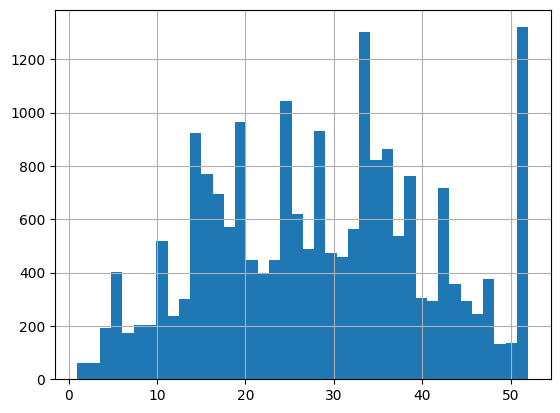

In [ ]:
df['HouseAge'].hist(bins=40)

Seem that with sufficient smoothing these data would be normally distributed, but we can see there are significant distortions to the histogram at this level of granularity, suggesting that the house ages are somewhat bunched around specific periods, possibly reflecting changes in house building levels from year to year.

As this is a bit of an edge-case, we can use a Quantile-Quantile plot (*Q-Q plot*) to investigate further. A Q-Q plot is a graphical tool used in statistics to assess if a dataset follows a particular theoretical distribution. It is a scatterplot created by plotting two sets of quantiles against one another - the theoretical quantiles from the chosen distribution on the x-axis, and the actual data quantiles on the y-axis.


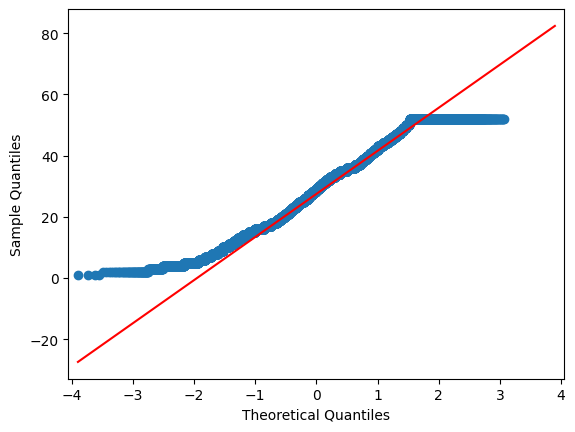

In [ ]:
# q-q plot of HouseAge:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot


# scaleHouseAge:


qq_plot = qqplot(df['HouseAge'] , scale=1 ,line='q')
pyplot.show()

From the Q-Q plot it is clear that while the data are normally distributed through the middle of the range, there are significant deviations from normality at the upper bound, as no houses are listed as older than 50 years, and at the lower, because the normal distribution would extend into the negative numbers, and the minimum possible age for a house is zero.

Should we impute with the median or the mean? Well in this case it probably doesn't make much difference - from the Q-Q plot we can guess that the two will be very similar, but let's check that quickly:

In [ ]:
print(f'The median of HouseAge is {df["HouseAge"].median()}')
print(f'The mean of HouseAge is {df["HouseAge"].mean()}')

The median of HouseAge is 29.0
The mean of HouseAge is 28.638488772491392


Let's pick the median in this case, and impute those values:

In [ ]:
# impute HouseAge with median:
df['HouseAge'] = df['HouseAge'].fillna(df['HouseAge'].median())

That might have seemed a frustrating number of tests to decide between two similar values, but the point is to illustrate the toolkit the analyst has at their disposal. Handling `null` values is as much art as it is science, and your decision of how to handle each case will depend on your intuitions about the underlying data, the results of various statistical tests, and the task you are trying to prepare the data for.

## Key Takeaways

- Most real-world datasets contain `null` values, and in many data analysis pipelines they will need to be handled
- Approaches for handling `null`s in structured data include deleting the row, deleting the entire column, and imputing the missing value
- Random and non-random missing values must be handled differently, with more complex techniques required to impute non-random values
- There are various strategies for imputing data. Deciding which to use depends on the complexity of the underlying data.
- Handling `null` values is as much art as science, and depends on the decisions and insights of the analyst